In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

cmap = plt.get_cmap("Set1")
colors = cmap.colors

In [77]:
run_id, run_path = get_latest_results_directory("../../results/compare-methods/")
# run_id = 89
# run_path = "C:/Users/Peter/Documents/Peter/9-Graduate-School/2-dsrg/explainable-ad/code/HEEAD/results/compare-methods/run-{:003d}".format(run_id)
fig_output_path = make_fig_directory(run_id)
found_ds, results = load_results(run_path, group_fields=["explainer"])

all_results = pd.DataFrame(columns=["dataset", "explainer", "n_samples", "n_samples_explained", "n_features", "accuracy", "precision", "recall", "f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard", "coverage_ratio", "mean_distance", "mean_length", "runtime", "clique_size", "init_time", "sample_runtime", "mdr"])

for ds in found_ds:
    results[ds]["sample_runtime"] = results[ds].runtime / results[ds].n_samples_explained * 1000
    results[ds]["init_time"] = results[ds]["init_time"] * 1000
    results[ds]["mdr"] = results[ds].mean_distance
    # results[ds]["mdr"] = results[ds].mean_distance / np.sqrt(results[ds].n_features)


for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)
idx_neg = all_results["clique_size"] < 0
all_results.loc[idx_neg, "clique_size"] = 0

found_explainers = all_results["explainer"].unique()
explainer_dict = {
    "AFT" : "AFT",
    "FACET" : "FACET",
    "FACETPaths" : "FACETPaths",
    "FACETTrees" : "FACETTrees",
    "FACETGrow" : "FACETGrow",
    "FACETIndex": "FACETIndex",
    "FACETBranchBound": "FACETBranchBound",
    "OCEAN" : "OCEAN",
    "MACE": "MACE"
}
explainer_colors = {
    "AFT" : colors[3] , # purple
    "FACET" : colors[0], # red
    "FACETPaths" : colors[0], # red
    "FACETTrees" : colors[0], # red
    "FACETGrow" : "orangered",
    "FACETIndex" : colors[0], # red
    "FACETBranchBound": "purple",
    "OCEAN" : colors[4], # orange
    "MACE": colors[1] # blue
}
explainer_names = []
for e in found_explainers:
    explainer_names.append(explainer_dict[e])

print("Generating figures for run-{:03d}".format(run_id))
print("Datasets included:")
for ds in found_ds:
    print("\t", ds)
print("Explainers included:")
for expl in found_explainers:
    print("\t", expl)

Generating figures for run-094
Datasets included:
	 cancer
	 glass
	 magic
	 spambase
	 vertebral
Explainers included:
	 FACETBranchBound
	 FACETGrow
	 FACETIndex
	 OCEAN


In [78]:
all_results.head()

,dataset,explainer,n_samples,n_samples_explained,n_features,accuracy,precision,recall,f1,avg_nnodes,...,mean_length,runtime,clique_size,init_time,sample_runtime,mdr,ext_avg,ext_max,ext_min,grown_clique_size
0,cancer,FACETBranchBound,20.0,20.0,30.0,0.955,0.952381,0.889004,0.910078,12.56,...,3.915000,4.280875,0.00,64.402032,214.043772,0.154080,276.115,627.7,131.0,-1.000
1,cancer,FACETGrow,20.0,20.0,30.0,0.955,0.952381,0.889004,0.910078,12.56,...,7.545000,0.032396,0.57,45.950103,1.619793,0.424413,-1.000,-1.0,-1.0,9.995
2,cancer,FACETIndex,20.0,20.0,30.0,0.955,0.952381,0.889004,0.910078,12.56,...,3.790000,3.734157,0.00,3133.356404,186.707851,0.165073,-1.000,-1.0,-1.0,-1.000
3,cancer,OCEAN,20.0,20.0,30.0,0.955,0.952381,0.889004,0.910078,12.56,...,3.836471,0.532153,0.00,0.000000,26.607629,0.154201,-1.000,-1.0,-1.0,-1.000
0,glass,FACETBranchBound,20.0,20.0,9.0,0.795,0.791477,0.850427,0.810027,11.50,...,1.810000,0.876564,0.00,65.300560,43.828180,0.051610,124.295,181.9,76.2,-1.000


In [79]:
def render_bar_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):
    fig, ax = plt.subplots()
    pos = np.arange(len(found_ds))
    bar_width = 0.15

    yvalues = all_results[yfeature].unique()

    for i in range(len(yvalues)):
        isExpl = all_results[yfeature] == yvalues[i]
        hbars = ax.barh(y=(pos + bar_width*i), width=all_results[isExpl][xfeature], height=bar_width, log=xlog, color=explainer_colors[yvalues[i]])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if not lloc:
        lloc = "best"
    plt.legend(explainer_names, loc=lloc, bbox_to_anchor=(1,1))
    plt.yticks(pos, found_ds)

    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name, bbox_inches="tight")

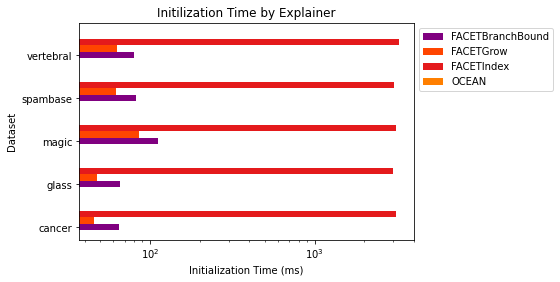

In [80]:
render_bar_plot("init_time", "explainer", "Initialization Time (ms)", "Dataset", "Initilization Time by Explainer", "inittime.png", xlog=True, lloc="upper left")

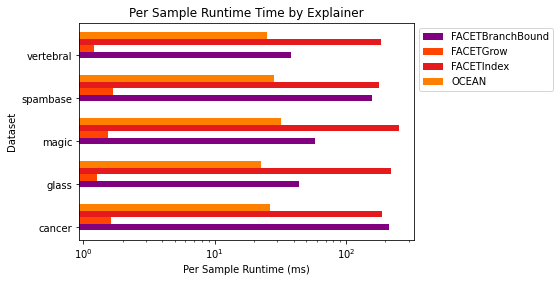

In [81]:
render_bar_plot("sample_runtime", "explainer", "Per Sample Runtime (ms)", "Dataset", "Per Sample Runtime Time by Explainer", "runtime.png", xlog=True, lloc="upper left")

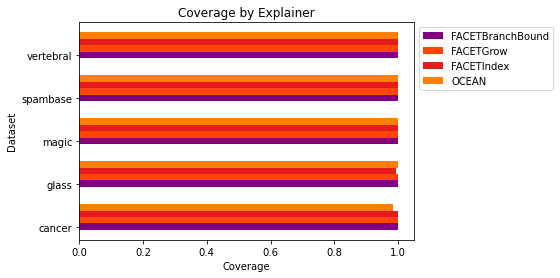

In [82]:
render_bar_plot("coverage_ratio", "explainer", "Coverage", "Dataset", "Coverage by Explainer", "coverage.png", lloc="upper left")

In [83]:
all_results.columns

Index(['dataset', 'explainer', 'n_samples', 'n_samples_explained',
       'n_features', 'accuracy', 'precision', 'recall', 'f1', 'avg_nnodes',
       'avg_nleaves', 'avg_depth', 'q', 'jaccard', 'coverage_ratio',
       'mean_distance', 'mean_length', 'runtime', 'clique_size', 'init_time',
       'sample_runtime', 'mdr', 'ext_avg', 'ext_max', 'ext_min',
       'grown_clique_size'],
      dtype='object')

In [84]:
all_results[["dataset", "explainer", "mean_distance", "mean_length"]].head()

,dataset,explainer,mean_distance,mean_length
0,cancer,FACETBranchBound,0.154080,3.915000
1,cancer,FACETGrow,0.424413,7.545000
2,cancer,FACETIndex,0.165073,3.790000
3,cancer,OCEAN,0.154201,3.836471
0,glass,FACETBranchBound,0.051610,1.810000


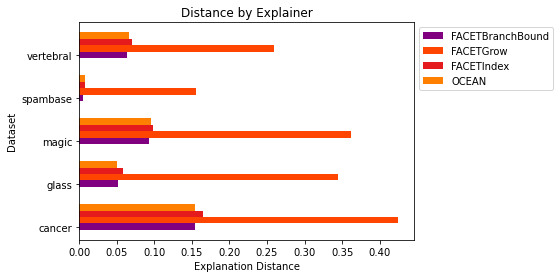

In [85]:
render_bar_plot("mdr", "explainer", "Explanation Distance", "Dataset", "Distance by Explainer", "distance.png", lloc="upper left")

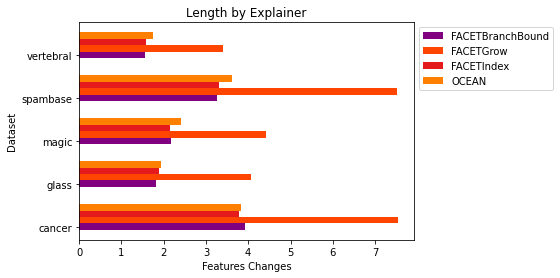

In [86]:
render_bar_plot("mean_length", "explainer", "Features Changes", "Dataset", "Length by Explainer", "length.png")

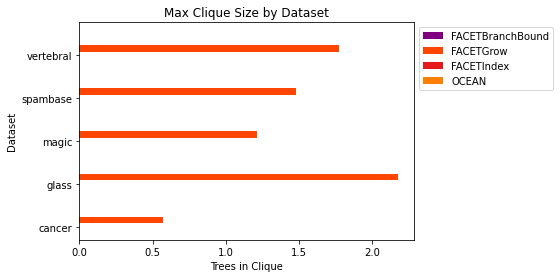

In [87]:
render_bar_plot("clique_size", "explainer", "Trees in Clique", "Dataset", "Max Clique Size by Dataset", "cliques.png")

In [88]:
if "OCEAN" in found_explainers and "FACETIndex" in found_explainers:
    idx_ocean = all_results["explainer"] == "OCEAN"
    all_results[idx_ocean][["dataset", "explainer", "mean_distance", "mdr"]]

In [89]:
if "OCEAN" in found_explainers and "FACETIndex" in found_explainers:
    idx_facet = all_results["explainer"] == "FACETIndex"
    all_results[idx_facet][["dataset", "explainer", "mean_distance", "mdr"]]

In [90]:
if "FACETBranchBound" in found_explainers and "FACETIndex" in found_explainers:
    print("Ratio to optimal")
    idx_fbb = all_results["explainer"] == "FACETBranchBound"
    for ds in found_ds:
        idx_ds = all_results["dataset"] == ds
        ratio_to_optimal = 0
        opt_dist = float(all_results[np.logical_and(idx_ds, idx_fbb)]["mean_distance"])
        facet_dist = float(all_results[np.logical_and(idx_ds, idx_facet)]["mean_distance"])
        print(ds, facet_dist / opt_dist)

Ratio to optimal
cancer 1.0713449566861764
glass 1.1235386084495402
magic 1.0551232459865272
spambase 1.6049371925901228
vertebral 1.0940686069688945


In [91]:
if "FACETGrow" in found_explainers:
    is_grow = all_results["explainer"] == "FACETGrow"
    avg_starting_clique = all_results[is_grow]["clique_size"].mean()
    avg_final_clique = all_results[is_grow]["grown_clique_size"].mean()
    print(avg_starting_clique)
    print(avg_final_clique)

1.4420000000000002
9.637000000000002


In [92]:
all_results.columns

Index(['dataset', 'explainer', 'n_samples', 'n_samples_explained',
       'n_features', 'accuracy', 'precision', 'recall', 'f1', 'avg_nnodes',
       'avg_nleaves', 'avg_depth', 'q', 'jaccard', 'coverage_ratio',
       'mean_distance', 'mean_length', 'runtime', 'clique_size', 'init_time',
       'sample_runtime', 'mdr', 'ext_avg', 'ext_max', 'ext_min',
       'grown_clique_size'],
      dtype='object')

In [93]:
if "FACETIndex" in found_explainers:
    isExpl = all_results["explainer"] == "FACETIndex"
    print("Hyper-Rectangle Enumeration Rate (rects / sec):")
    for ds in found_ds:
        n_rects = 0.8 * DS_DIMENSIONS[ds][0]
        is_ds = all_results["dataset"] == ds
        is_value = (np.logical_and(isExpl, is_ds))
        ds_init_time = all_results[is_value]["init_time"].iloc[0]
        print(ds, n_rects / (ds_init_time / 1000))

    all_results[isExpl][["dataset", "init_time", "n_samples"]].head(50)

Hyper-Rectangle Enumeration Rate (rects / sec):
cancer 145.02020880093943
glass 43.24960798757578
magic 4856.4864288944245
spambase 1206.9369038662505
vertebral 76.07932613228404
